## Carga de Arquivos do Treino

In [42]:
import pandas as pd
import os

data_path = "../data/raw/treino/"
arquivos_treino = [f for f in os.listdir(data_path) if f.startswith("treino_parte")]

# Carregar os arquivos de treino
df_list = [pd.read_csv(os.path.join(data_path, file)) for file in arquivos_treino]
df_treino = pd.concat(df_list, ignore_index=True)

df_treino.head()

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,timestampHistory_new
0,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,"c8aab885-433d-4e46-8066-479f40ba7fb2, 68d2039c...","1657146417045, 1657146605778, 1657146698738","76, 38, 41","20380, 21184, 35438","50.3, 18.18, 16.46","2, 1, 1","1657146417045, 1657146605778, 1657146698738"
1,2c1080975e257ed630e26679edbe4d5c850c65f3e09f65...,Non-Logged,60,"3325b5a1-979a-4cb3-82b6-63905c9edbe8, fe856057...","1656684240278, 1656761266729, 1656761528085, 1...","7, 80, 2, 1, 7, 62, 26, 44, 4, 4, 14, 45, 13, ...","6049, 210489, 8672, 10000, 30000, 123007, 9965...","25.35, 45.66, 35.3, 28.05, 36.53, 47.57, 55.33...","1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1...","1656684240278, 1656761266729, 1656761528085, 1..."
2,0adffd7450d3b9840d8c6215f0569ad942e782fb19b805...,Logged,107,"04756569-593e-4133-a95a-83d35d43dbbd, 29b6b142...","1656678946256, 1656701076495, 1656701882565, 1...","0, 0, 0, 0, 0, 44, 0, 0, 2, 1, 0, 0, 0, 44, 0,...","311274, 140000, 32515, 157018, 118689, 159243,...","67.58, 47.22, 41.52, 63.09, 51.38, 65.11, 71.9...","1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1...","1656678946256, 1656701076495, 1656701882565, 1..."
3,c1e8d644329a78ea1f994292db624c57980b2886cfbc2d...,Non-Logged,56,"1f2b9c2f-a2d2-4192-b009-09065da8ec23, 04756569...","1658333312180, 1658404553818, 1658408449062, 1...","8, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 1...","182696, 91925, 30000, 273655, 126409, 42980, 1...","58.26, 72.66, 22.57, 59.89, 40.36, 36.35, 14.7...","1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","1658333312180, 1658404553818, 1658408449062, 1..."
4,e777d1f31d4d955b63d60acc13df336d3903f52ab8f8f4...,Non-Logged,4,"bebdeb3e-1699-43e0-a1b8-989f5a6ab679, f4b484a7...","1658766608801, 1658766608801, 1660084035094, 1...","579, 579, 7, 2","801396, 801396, 10000, 10000","78.74, 78.74, 16.71, 9.34","7, 7, 1, 1","1658766608801, 1658766608801, 1660084035094, 1..."


## Carregar os arquivos de itens


In [43]:
itens_path = "../data/raw/itens/"
arquivos_itens = [f for f in os.listdir(itens_path) if f.startswith("itens_parte")]

# Carregar os arquivos de itens
df_itens_list = [pd.read_csv(os.path.join(itens_path, file)) for file in arquivos_itens]
df_itens = pd.concat(df_itens_list, ignore_index=True)

df_itens.head()


,page,url,issued,modified,title,body,caption
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...
4,9dff71eb-b681-40c7-ac8d-68017ac36675,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic..."


## Dividindo arquivos em partes menores
Exporte os arquivos para data/raw/ itens e treino e rode para gerar novas partes

In [ ]:
# import pandas as pd
# import os

# output_dir = "./data/processed/"

# os.makedirs(output_dir, exist_ok=True)

# def dividir_arquivo(df, num_partes, nome_base):
#     tamanho_parte = len(df) // num_partes
#     for i in range(num_partes):
#         inicio = i * tamanho_parte
#         fim = (i + 1) * tamanho_parte if i < num_partes - 1 else len(df)
#         df.iloc[inicio:fim].to_csv(f"{output_dir}{nome_base}_parte_{i+1}.csv", index=False)

# num_partes_treino = 60
# num_partes_itens = 30

# dividir_arquivo(df_treino, num_partes_treino, "treino")
# dividir_arquivo(df_itens, num_partes_itens, "itens")


Arquivos divididos e salvos em ./data/processed/


## Distribuição de Usuários e Tipos
verificando quantos usuários estão logados vs não logados


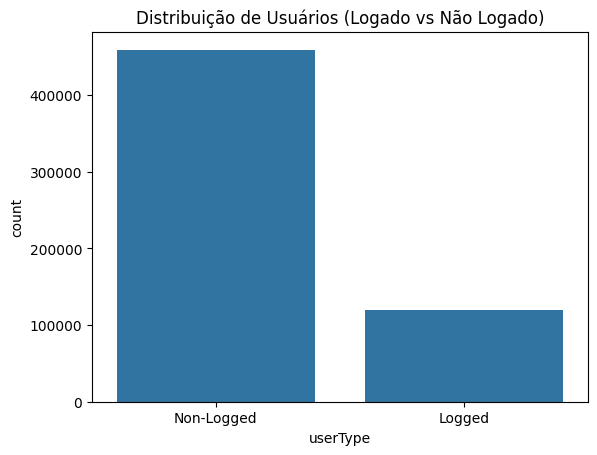

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem de tipos de usuários
sns.countplot(x=df_treino['userType'])
plt.title("Distribuição de Usuários (Logado vs Não Logado)")
plt.show()


## Análise dos Turnos de mais acesso

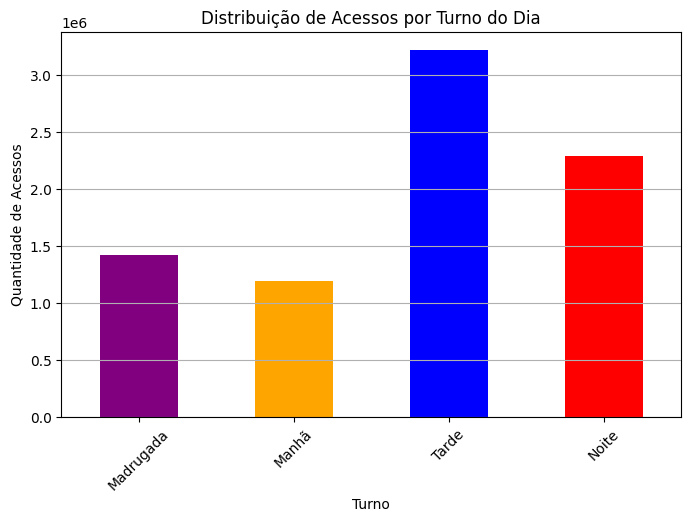

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

df_timestamps = df_treino[['timestampHistory_new']].dropna().copy()
df_timestamps['timestampHistory_new'] = df_timestamps['timestampHistory_new'].astype(str).str.split(',')  # Separar timestamps
df_timestamps = df_timestamps.explode('timestampHistory_new')  # Criar linhas separadas

# Converter para datetime
df_timestamps['timestampHistory_new'] = pd.to_numeric(df_timestamps['timestampHistory_new'], errors='coerce')
df_timestamps.dropna(subset=['timestampHistory_new'], inplace=True)  # Remover valores inválidos
df_timestamps['timestampHistory_new'] = pd.to_datetime(df_timestamps['timestampHistory_new'], unit='ms')  # Converter para datetime

df_timestamps['hora'] = df_timestamps['timestampHistory_new'].dt.hour

def classificar_turno(hora):
    if 5 <= hora < 12:
        return "Manhã"
    elif 12 <= hora < 18:
        return "Tarde"
    elif 18 <= hora < 23:
        return "Noite"
    else:
        return "Madrugada"

df_timestamps['turno'] = df_timestamps['hora'].apply(classificar_turno)

turno_counts = df_timestamps['turno'].value_counts().reindex(["Madrugada", "Manhã", "Tarde", "Noite"])

plt.figure(figsize=(8,5))
turno_counts.plot(kind='bar', color=['purple', 'orange', 'blue', 'red'])
plt.title("Distribuição de Acessos por Turno do Dia")
plt.xlabel("Turno")
plt.ylabel("Quantidade de Acessos")
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


## Tempo Médio por Turno

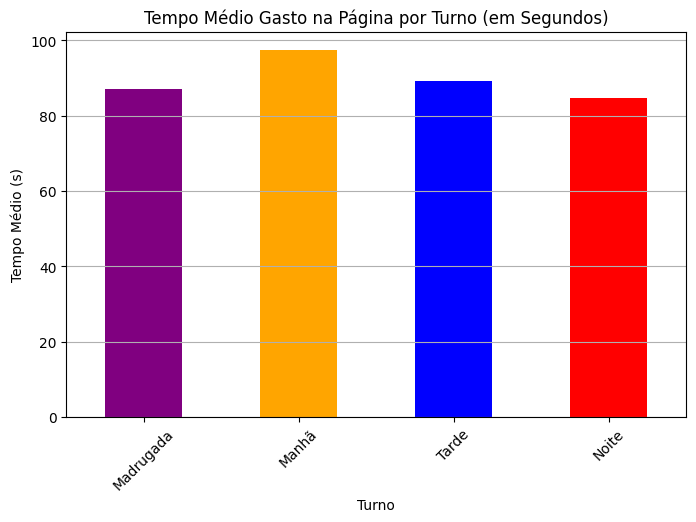

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_timestamps = df_treino[['timestampHistory_new', 'timeOnPageHistory']].dropna().copy()

df_timestamps['timestampHistory_new'] = df_timestamps['timestampHistory_new'].astype(str).str.split(',')
df_timestamps['timeOnPageHistory'] = df_timestamps['timeOnPageHistory'].astype(str).str.split(',')

df_timestamps = df_timestamps.explode(['timestampHistory_new', 'timeOnPageHistory'])

# Converter para datetime
df_timestamps['timestampHistory_new'] = pd.to_numeric(df_timestamps['timestampHistory_new'], errors='coerce')
df_timestamps.dropna(subset=['timestampHistory_new'], inplace=True)
df_timestamps['timestampHistory_new'] = pd.to_datetime(df_timestamps['timestampHistory_new'], unit='ms')

# Criar nova coluna de hora
df_timestamps['hora'] = df_timestamps['timestampHistory_new'].dt.hour

# Converte parasegundos
df_timestamps['timeOnPageHistory'] = pd.to_numeric(df_timestamps['timeOnPageHistory'], errors='coerce')
df_timestamps['timeOnPageHistory'] = df_timestamps['timeOnPageHistory'] / 1000  # Convertendo para segundos

def classificar_turno(hora):
    if 5 <= hora < 12:
        return "Manhã"
    elif 12 <= hora < 18:
        return "Tarde"
    elif 18 <= hora < 23:
        return "Noite"
    else:
        return "Madrugada"

df_timestamps['turno'] = df_timestamps['hora'].apply(classificar_turno)

tempo_medio_turno = df_timestamps.groupby('turno')['timeOnPageHistory'].mean().reindex(["Madrugada", "Manhã", "Tarde", "Noite"])

plt.figure(figsize=(8,5))
tempo_medio_turno.plot(kind='bar', color=['purple', 'orange', 'blue', 'red'])
plt.title("Tempo Médio Gasto na Página por Turno (em Segundos)")
plt.xlabel("Turno")
plt.ylabel("Tempo Médio (s)")
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()
